# Dimensionality Reduction
- Principal Component Analysis 

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

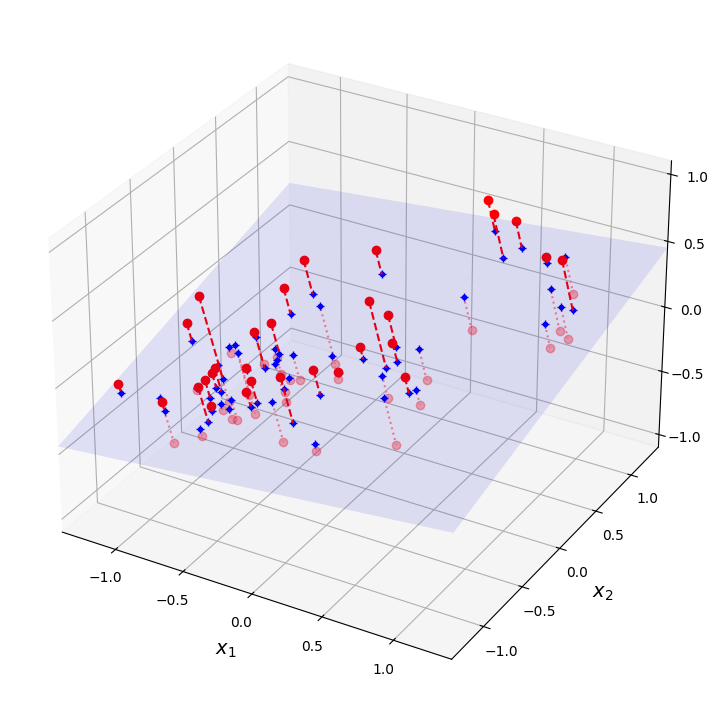

In [6]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()

# Principal Component Analysis 

- Identifies hyperplane that lies closest to the data, then projects the data onto that plane

- before you can project onto lower-dimensional plane hyperplane, you fitst need to choose the correct hypeplane
- PCA identifies the axis that accounts for the largest amount of variance in the training set 
-  It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance (including in higher dimensions)

## Choosing the right number of dimension

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently
large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimen sionality for data visualization—in that case you will generally want to reduce the dimensionality down to 2 or 3.

In [8]:
import numpy as np

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [9]:
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

# Projecting Down d-dimensions

In [12]:
W2  = Vt[:2].T
X2D = X_centered @ W2

# Explained Variance Ratio

In [13]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [15]:
1 - pca.explained_variance_ratio_.sum()

np.float64(0.0)

In [16]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

In [17]:
d

np.int64(154)

In [18]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [19]:
pca.n_components_

np.int64(154)

In [20]:
pca.explained_variance_ratio_.sum()

np.float64(0.9501960192613033)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [22]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': np.int64(475), 'pca__n_components': np.int64(57)}


In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [ ]:
grid_search.best_params_